# Ethereum Code Chunking Analysis

This notebook analyzes code chunking patterns on Ethereum mainnet to understand:
- How much of contract bytecode is actually accessed during execution
- Chunk utilization patterns across different contracts
- Relationships between contract characteristics and access patterns

## Dataset Schema
- `block_number`: Block number on Ethereum mainnet
- `address`: Contract address
- `bytecode_size`: Total size of the contract code
- `bytes_count`: Number of bytes accessed
- `chunks_count`: Number of chunks accessed
- `code_ops_count`: Number of code-related operations (EXTCODESIZE, EXTCODECOPY, EXTCODEHASH, CODECOPY, CODESIZE)

**Note**: Total chunks = bytecode_size / 32 (chunks are 32 bytes each)

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print("Libraries imported successfully")

Libraries imported successfully


## 1. Data Loading and Initial Exploration

In [108]:
# Load both datasets and merge them
data_files = ['../results/analysis-0.csv', '../results/analysis-1.csv']
dataframes = []

for file_path in data_files:
    try:
        df_temp = pd.read_csv(file_path)
        print(f"Loaded {file_path}: {df_temp.shape}")
        dataframes.append(df_temp)
    except FileNotFoundError:
        print(f"Warning: {file_path} not found, skipping...")

# Merge all dataframes
df = pd.concat(dataframes, ignore_index=True)

print(f"\nCombined dataset shape: {df.shape}")
print(f"\nDataset info:")
print(df.info())
print(f"\nFirst few rows:")
df.head(10)

Loaded ../results/analysis-0.csv: (1252832, 6)
Loaded ../results/analysis-1.csv: (1207497, 6)

Combined dataset shape: (2460329, 6)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2460329 entries, 0 to 2460328
Data columns (total 6 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   block_number    int64 
 1   address         object
 2   bytecode_size   int64 
 3   bytes_count     int64 
 4   chunks_count    int64 
 5   code_ops_count  int64 
dtypes: int64(5), object(1)
memory usage: 112.6+ MB
None

First few rows:


,block_number,address,bytecode_size,bytes_count,chunks_count,code_ops_count
0,22000000,0x8ad599c3A0ff1De082011EFDDc58f1908eb6e6D8,22142,5136,215,1
1,22000000,0x85a471E728F8F0932694d349993DC9A599a5978c,19080,2394,93,0
2,22000000,0x5Ebac8dbfbBA22168471b0f914131d1976536A25,11329,2762,114,0
3,22000000,0x4512759606F9e680361dD76c4C17f92031De7AcD,15159,1209,54,6
4,22000000,0x4C19596f5aAfF459fA38B0f7eD92F11AE6543784,2700,143,6,2
5,22000000,0x8CC51c532f5A71210D19d87D3d8a1E6F50AD583c,2112,283,16,0
6,22000000,0x1008FAbD07aBd93a7D9bB81803a89cC3a834E1A9,7265,2305,104,0
7,22000000,0xF0262815AA54aEa5D9EEc6eA09937C6723b7Bd21,6164,316,16,0
8,22000000,0x68d30f47F19c07bCCEf4Ac7FAE2Dc12FCa3e0dC9,170,103,4,0
9,22000000,0x5141B82f5fFDa4c6fE1E372978F1C5427640a190,17346,2012,82,1


In [109]:
# Basic statistics
print("Basic Statistics:")
print(df.describe())

print(f"\nUnique blocks: {df['block_number'].nunique()}")
print(f"Unique addresses: {df['address'].nunique()}")
print(f"Total records: {len(df)}")

Basic Statistics:
       block_number  bytecode_size   bytes_count  chunks_count  code_ops_count
count  2.460329e+06   2.460329e+06  2.460329e+06  2.460329e+06    2.460329e+06
mean   2.200501e+07   8.768761e+03  1.484269e+03  6.381641e+01    1.638204e+00
std    2.919531e+03   8.049675e+03  1.848794e+03  7.346462e+01    1.054320e+01
min    2.200000e+07   3.000000e+00  0.000000e+00  0.000000e+00    0.000000e+00
25%    2.200248e+07   1.654000e+03  2.170000e+02  1.100000e+01    0.000000e+00
50%    2.200490e+07   6.635000e+03  7.160000e+02  3.500000e+01    0.000000e+00
75%    2.200759e+07   1.393600e+04  2.097000e+03  9.400000e+01    1.000000e+00
max    2.201000e+07   2.457600e+04  2.285500e+04  7.180000e+02    2.176000e+03

Unique blocks: 9993
Unique addresses: 324127
Total records: 2460329


## 2. Data Cleaning

In [110]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Check for empty rows (all NaN)
empty_rows = df.isnull().all(axis=1).sum()
print(f"\nEmpty rows: {empty_rows}")

# Remove any empty rows
df_clean = df.dropna(how='all')
print(f"Shape after removing empty rows: {df_clean.shape}")

Missing values per column:
block_number      0
address           0
bytecode_size     0
bytes_count       0
chunks_count      0
code_ops_count    0
dtype: int64

Empty rows: 0
Shape after removing empty rows: (2460329, 6)


In [111]:
# Check for duplicate (block_number, address) combinations
duplicates = df_clean.duplicated(subset=['block_number', 'address']).sum()
print(f"Duplicate block_number + address combinations: {duplicates}")

if duplicates > 0:
    print("\nDuplicate entries:")
    duplicate_mask = df_clean.duplicated(subset=['block_number', 'address'], keep=False)
    print(df_clean[duplicate_mask].sort_values(['block_number', 'address']))
    
    # Keep first occurrence of duplicates
    df_clean = df_clean.drop_duplicates(subset=['block_number', 'address'], keep='first')
    print(f"\nShape after removing duplicates: {df_clean.shape}")
else:
    print("No duplicates found - data is clean!")

Duplicate block_number + address combinations: 8

Duplicate entries:
       block_number                                     address  \
95968      22000464  0x0190a2328e072Fc5a7fA00F6C9ae2a16c7F4E32a   
96110      22000464  0x0190a2328e072Fc5a7fA00F6C9ae2a16c7F4E32a   
95978      22000464  0x1CfdeB61648C157e438D3C34455D6001a0F5ca6F   
96113      22000464  0x1CfdeB61648C157e438D3C34455D6001a0F5ca6F   
95882      22000464  0x2054Df898bB8CCbF532eCF067291D994a8a9Dc8A   
96109      22000464  0x2054Df898bB8CCbF532eCF067291D994a8a9Dc8A   
96103      22000464  0x49fb8ad7578148E17c3eF0C344CE23A66ed372C4   
96111      22000464  0x49fb8ad7578148E17c3eF0C344CE23A66ed372C4   
95896      22000464  0x54D2252757e1672EEaD234D27B1270728fF90581   
96108      22000464  0x54D2252757e1672EEaD234D27B1270728fF90581   
95989      22000464  0x5D4Aa78B08Bc7C530e21bf7447988b1Be7991322   
96115      22000464  0x5D4Aa78B08Bc7C530e21bf7447988b1Be7991322   
95983      22000464  0x807cF9A772d5a3f9CeFBc1192e939D62f0D9b

In [112]:
# Check for any data quality issues
print("Data Quality Checks:")
print(f"Records with bytecode_size = 0: {(df_clean['bytecode_size'] == 0).sum()}")
print(f"Records with bytes_count > bytecode_size: {(df_clean['bytes_count'] > df_clean['bytecode_size']).sum()}")

# Check block range (should include blocks 22000000 to 22010000 inclusive)
print(f"\nBlock Range Analysis:")
print(f"Block range in data: {df_clean['block_number'].min()} - {df_clean['block_number'].max()}")
print(f"Expected range: 22000000 - 22010000")

# Validate expected block range
expected_min_block = 22000000
expected_max_block = 22010000
actual_min_block = df_clean['block_number'].min()
actual_max_block = df_clean['block_number'].max()

blocks_in_expected_range = df_clean[
    (df_clean['block_number'] >= expected_min_block) & 
    (df_clean['block_number'] <= expected_max_block)
]

print(f"\nBlock Range Validation:")
print(f"Records in expected range (22000000-22010000): {len(blocks_in_expected_range)} ({len(blocks_in_expected_range)/len(df_clean)*100:.1f}%)")

# Detailed block analysis
expected_block_count = expected_max_block - expected_min_block + 1
actual_unique_blocks = df_clean['block_number'].nunique()
print(f"\nDetailed Block Analysis:")
print(f"Expected total blocks: {expected_block_count:,}")
print(f"Actual unique blocks: {actual_unique_blocks:,}")
print(f"Missing blocks: {expected_block_count - actual_unique_blocks}")

if expected_block_count != actual_unique_blocks:
    # Find missing blocks
    expected_blocks = set(range(expected_min_block, expected_max_block + 1))
    actual_blocks = set(df_clean['block_number'].unique())
    missing_blocks = sorted(expected_blocks - actual_blocks)
    
    print(f"\n❌ Missing blocks ({len(missing_blocks)}):")
    if len(missing_blocks) <= 20:  # Only show if reasonable number
        print(f"   {missing_blocks}")
    else:
        print(f"   First 10: {missing_blocks[:10]}")
        print(f"   Last 10: {missing_blocks[-10:]}")
        
    # Check for any blocks outside expected range
    extra_blocks = sorted(actual_blocks - expected_blocks)
    if extra_blocks:
        print(f"\n⚠️  Blocks outside expected range ({len(extra_blocks)}):")
        if len(extra_blocks) <= 20:
            print(f"   {extra_blocks}")
        else:
            print(f"   First 10: {extra_blocks[:10]}")
            print(f"   Last 10: {extra_blocks[-10:]}")

if actual_min_block < expected_min_block or actual_max_block > expected_max_block:
    print(f"⚠️  Warning: Data contains blocks outside expected range")
    
if len(blocks_in_expected_range) == 0:
    print(f"❌ Error: No blocks found in expected range!")
else:
    print(f"✅ Data contains blocks in expected range")

# Block coverage statistics
block_counts = df_clean['block_number'].value_counts().sort_index()
print(f"\nBlock Coverage Statistics:")
print(f"Min contracts per block: {block_counts.min()}")
print(f"Max contracts per block: {block_counts.max()}")
print(f"Median contracts per block: {block_counts.median():.1f}")
print(f"Blocks with 0 contracts: {expected_block_count - actual_unique_blocks}")
print("Missing blocks have 0 contract-related transactions (manually checked)")

# Show distribution of contracts per block
print(f"\nContract Distribution Summary:")
print(f"Blocks with <100 contracts: {(block_counts < 100).sum()}")
print(f"Blocks with 100-500 contracts: {((block_counts >= 100) & (block_counts < 500)).sum()}")
print(f"Blocks with 500+ contracts: {(block_counts >= 500).sum()}")

# Remove records with bytecode_size = 0 as they're not meaningful for analysis
df_clean = df_clean[df_clean['bytecode_size'] > 0]
print(f"\nFinal cleaned dataset shape: {df_clean.shape}")

# Additional validation for large dataset
print(f"\nDataset Scale:")
print(f"Total contracts: {len(df_clean):,}")
print(f"Unique addresses: {df_clean['address'].nunique():,}")
print(f"Average contracts per block: {len(df_clean) / df_clean['block_number'].nunique():.1f}")

Data Quality Checks:
Records with bytecode_size = 0: 0
Records with bytes_count > bytecode_size: 0

Block Range Analysis:
Block range in data: 22000000 - 22010000
Expected range: 22000000 - 22010000

Block Range Validation:
Records in expected range (22000000-22010000): 2460321 (100.0%)

Detailed Block Analysis:
Expected total blocks: 10,001
Actual unique blocks: 9,993
Missing blocks: 8

❌ Missing blocks (8):
   [22000150, 22000719, 22001061, 22002405, 22004951, 22006220, 22006786, 22006898]
✅ Data contains blocks in expected range

Block Coverage Statistics:
Min contracts per block: 3
Max contracts per block: 649
Median contracts per block: 239.0
Blocks with 0 contracts: 8
Missing blocks have 0 contract-related transactions (manually checked)

Contract Distribution Summary:
Blocks with <100 contracts: 805
Blocks with 100-500 contracts: 9072
Blocks with 500+ contracts: 116

Final cleaned dataset shape: (2460321, 6)

Dataset Scale:
Total contracts: 2,460,321
Unique addresses: 324,127
Av

## 3. Feature Engineering - Calculate Key Metrics

In [113]:
# Calculate derived metrics
df_analysis = df_clean.copy()

# Calculate total chunks (bytecode_size / 32)
df_analysis['total_chunks'] = np.ceil(df_analysis['bytecode_size'] / 32).astype(int)

# Calculate proportions (main research questions)
df_analysis['bytes_accessed_ratio'] = df_analysis['bytes_count'] / df_analysis['bytecode_size']
df_analysis['chunks_accessed_ratio'] = df_analysis['chunks_count'] / df_analysis['total_chunks']

# Additional metrics for deeper analysis
df_analysis['avg_bytes_per_chunk'] = df_analysis['bytes_count'] / df_analysis['chunks_count']
df_analysis['code_ops_per_byte'] = df_analysis['code_ops_count'] / df_analysis['bytecode_size']

# Contract size categories
size_category_labels = ['Tiny (<1KiB)', 'Small (1-5KiB)', 'Medium (5-10KiB)', 
                        'Large (10-20KiB)', 'Very Large (20-24KiB)', 'Max (24KiB)']
df_analysis['size_category'] = pd.cut(df_analysis['bytecode_size'], 
                                     bins=[0, 1023, 5119, 10239, 20479, 24575, float('inf')],
                                     labels=size_category_labels)

print("Calculated metrics:")
print(df_analysis[['bytes_accessed_ratio', 'chunks_accessed_ratio', 'total_chunks', 'avg_bytes_per_chunk']].describe())

print(f"\nContract size distribution:")
print(df_analysis['size_category'].value_counts())

Calculated metrics:
       bytes_accessed_ratio  chunks_accessed_ratio  total_chunks  \
count          2.460321e+06           2.460321e+06  2.460321e+06   
mean           3.000115e-01           3.681864e-01  2.744969e+02   
std            2.959514e-01           2.938890e-01  2.515054e+02   
min            0.000000e+00           0.000000e+00  1.000000e+00   
25%            1.017159e-01           1.666667e-01  5.200000e+01   
50%            1.927932e-01           2.727273e-01  2.080000e+02   
75%            3.320520e-01           4.615385e-01  4.360000e+02   
max            1.000000e+00           1.000000e+00  7.680000e+02   

       avg_bytes_per_chunk  
count         2.459328e+06  
mean          2.192306e+01  
std           3.249111e+00  
min           1.000000e+00  
25%           1.963636e+01  
50%           2.200000e+01  
75%           2.442105e+01  
max           3.200000e+01  

Contract size distribution:
size_category
Small (1-5KiB)           622277
Large (10-20KiB)         556996

## 4. Primary Research Questions Analysis

### Question 1: What is the proportion of bytes accessed over bytecode size?

Bytes Accessed Ratio Statistics:
count    2.460321e+06
mean     3.000115e-01
std      2.959514e-01
min      0.000000e+00
25%      1.017159e-01
50%      1.927932e-01
75%      3.320520e-01
max      1.000000e+00
Name: bytes_accessed_ratio, dtype: float64


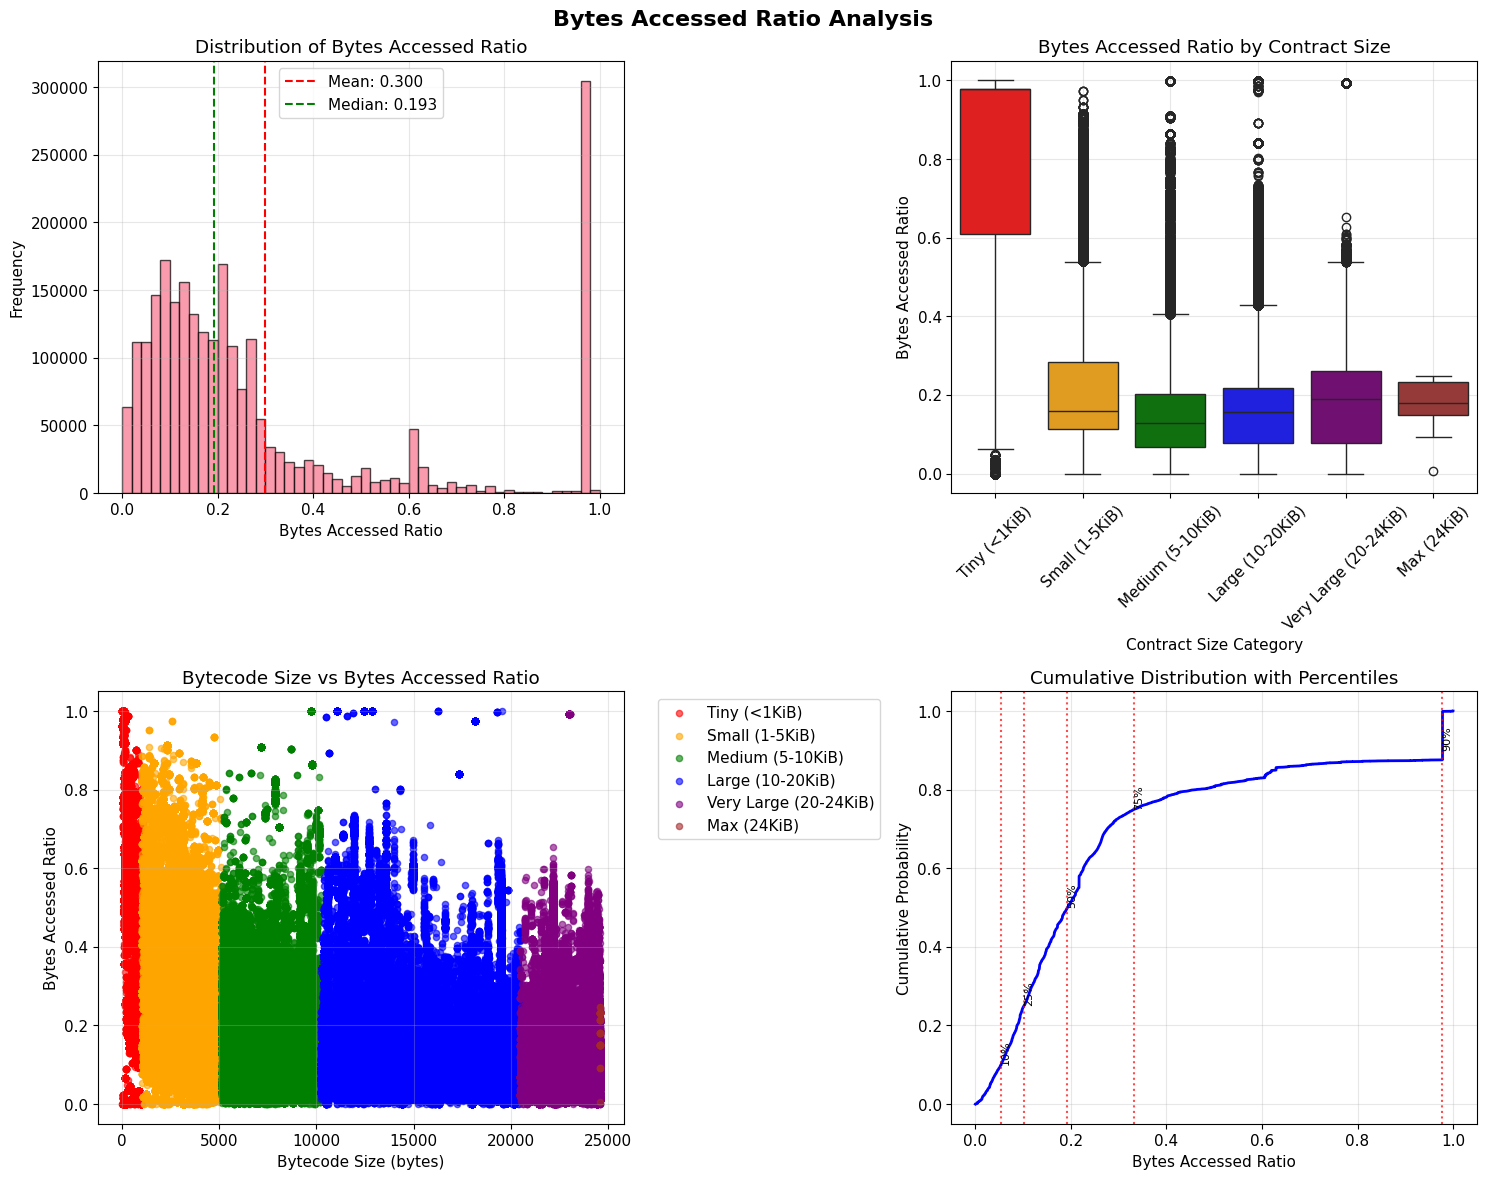


KEY INSIGHTS - Bytes Accessed Ratio:
• Average proportion of bytes accessed: 30.0%
• Median proportion of bytes accessed: 19.3%
• 10th percentile: 5.4%
• 90th percentile: 97.8%
• Contracts with >50% bytes accessed: 474,225 (19.3%)

📊 By Contract Size:
• Tiny (<1KiB): 493,872 contracts, avg 77.9%, median 97.8%
• Small (1-5KiB): 622,277 contracts, avg 21.7%, median 15.9%
• Medium (5-10KiB): 389,900 contracts, avg 15.0%, median 12.7%
• Large (10-20KiB): 556,996 contracts, avg 16.3%, median 15.6%
• Very Large (20-24KiB): 397,220 contracts, avg 17.4%, median 18.8%
• Max (24KiB): 56 contracts, avg 18.6%, median 18.0%


In [114]:
# Analysis of bytes accessed ratio
bytes_ratio_stats = df_analysis['bytes_accessed_ratio'].describe()
print("Bytes Accessed Ratio Statistics:")
print(bytes_ratio_stats)

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Bytes Accessed Ratio Analysis', fontsize=16, fontweight='bold')

# Histogram
axes[0,0].hist(df_analysis['bytes_accessed_ratio'], bins=50, alpha=0.7, edgecolor='black')
axes[0,0].axvline(bytes_ratio_stats['mean'], color='red', linestyle='--', label=f'Mean: {bytes_ratio_stats["mean"]:.3f}')
axes[0,0].axvline(bytes_ratio_stats['50%'], color='green', linestyle='--', label=f'Median: {bytes_ratio_stats["50%"]:.3f}')
axes[0,0].set_xlabel('Bytes Accessed Ratio')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Distribution of Bytes Accessed Ratio')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Colored box plot by contract size using seaborn
sns.boxplot(data=df_analysis, x='size_category', y='bytes_accessed_ratio', 
            palette=['red', 'orange', 'green', 'blue', 'purple', 'brown'],
            ax=axes[0,1])
axes[0,1].set_title('Bytes Accessed Ratio by Contract Size')
axes[0,1].set_xlabel('Contract Size Category')
axes[0,1].set_ylabel('Bytes Accessed Ratio')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(True, alpha=0.3)

# Scatter plot with color coding by size
size_colors = {size_category_labels[0]: 'red', size_category_labels[1]: 'orange', size_category_labels[2]: 'green', 
               size_category_labels[3]: 'blue', size_category_labels[4]: 'purple', size_category_labels[5]: 'brown'}
for size_cat, color in size_colors.items():
    mask = df_analysis['size_category'] == size_cat
    if mask.any():
        axes[1,0].scatter(df_analysis[mask]['bytecode_size'], 
                         df_analysis[mask]['bytes_accessed_ratio'], 
                         alpha=0.6, label=size_cat, color=color, s=20)

axes[1,0].set_xlabel('Bytecode Size (bytes)')
axes[1,0].set_ylabel('Bytes Accessed Ratio')
axes[1,0].set_title('Bytecode Size vs Bytes Accessed Ratio')
axes[1,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1,0].grid(True, alpha=0.3)

# Cumulative distribution with percentile markers
sorted_ratios = np.sort(df_analysis['bytes_accessed_ratio'])
y_values = np.arange(1, len(sorted_ratios) + 1) / len(sorted_ratios)
axes[1,1].plot(sorted_ratios, y_values, linewidth=2, color='blue')

# Add percentile markers
percentiles = [10, 25, 50, 75, 90]
for p in percentiles:
    val = np.percentile(df_analysis['bytes_accessed_ratio'], p)
    axes[1,1].axvline(val, color='red', linestyle=':', alpha=0.7)
    axes[1,1].text(val, p/100, f'{p}%', rotation=90, verticalalignment='bottom', fontsize=8)

axes[1,1].set_xlabel('Bytes Accessed Ratio')
axes[1,1].set_ylabel('Cumulative Probability')
axes[1,1].set_title('Cumulative Distribution with Percentiles')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Enhanced insights with contract size breakdown
print(f"\nKEY INSIGHTS - Bytes Accessed Ratio:")
print(f"• Average proportion of bytes accessed: {bytes_ratio_stats['mean']:.1%}")
print(f"• Median proportion of bytes accessed: {bytes_ratio_stats['50%']:.1%}")
print(f"• 10th percentile: {np.percentile(df_analysis['bytes_accessed_ratio'], 10):.1%}")
print(f"• 90th percentile: {np.percentile(df_analysis['bytes_accessed_ratio'], 90):.1%}")
print(f"• Contracts with >50% bytes accessed: {(df_analysis['bytes_accessed_ratio'] > 0.5).sum():,} ({(df_analysis['bytes_accessed_ratio'] > 0.5).mean():.1%})")

# Size-specific insights
print(f"\n📊 By Contract Size:")
size_summary = df_analysis.groupby('size_category')['bytes_accessed_ratio'].agg(['count', 'mean', 'median']).round(3)
for size_cat in size_category_labels:
    if size_cat in size_summary.index:
        count = size_summary.loc[size_cat, 'count']
        mean_ratio = size_summary.loc[size_cat, 'mean']
        median_ratio = size_summary.loc[size_cat, 'median']
        print(f"• {size_cat}: {count:,} contracts, avg {mean_ratio:.1%}, median {median_ratio:.1%}")

### Question 2: What is the proportion of chunks accessed over total chunks?

Chunks Accessed Ratio Statistics:
count    2.460321e+06
mean     3.681864e-01
std      2.938890e-01
min      0.000000e+00
25%      1.666667e-01
50%      2.727273e-01
75%      4.615385e-01
max      1.000000e+00
Name: chunks_accessed_ratio, dtype: float64


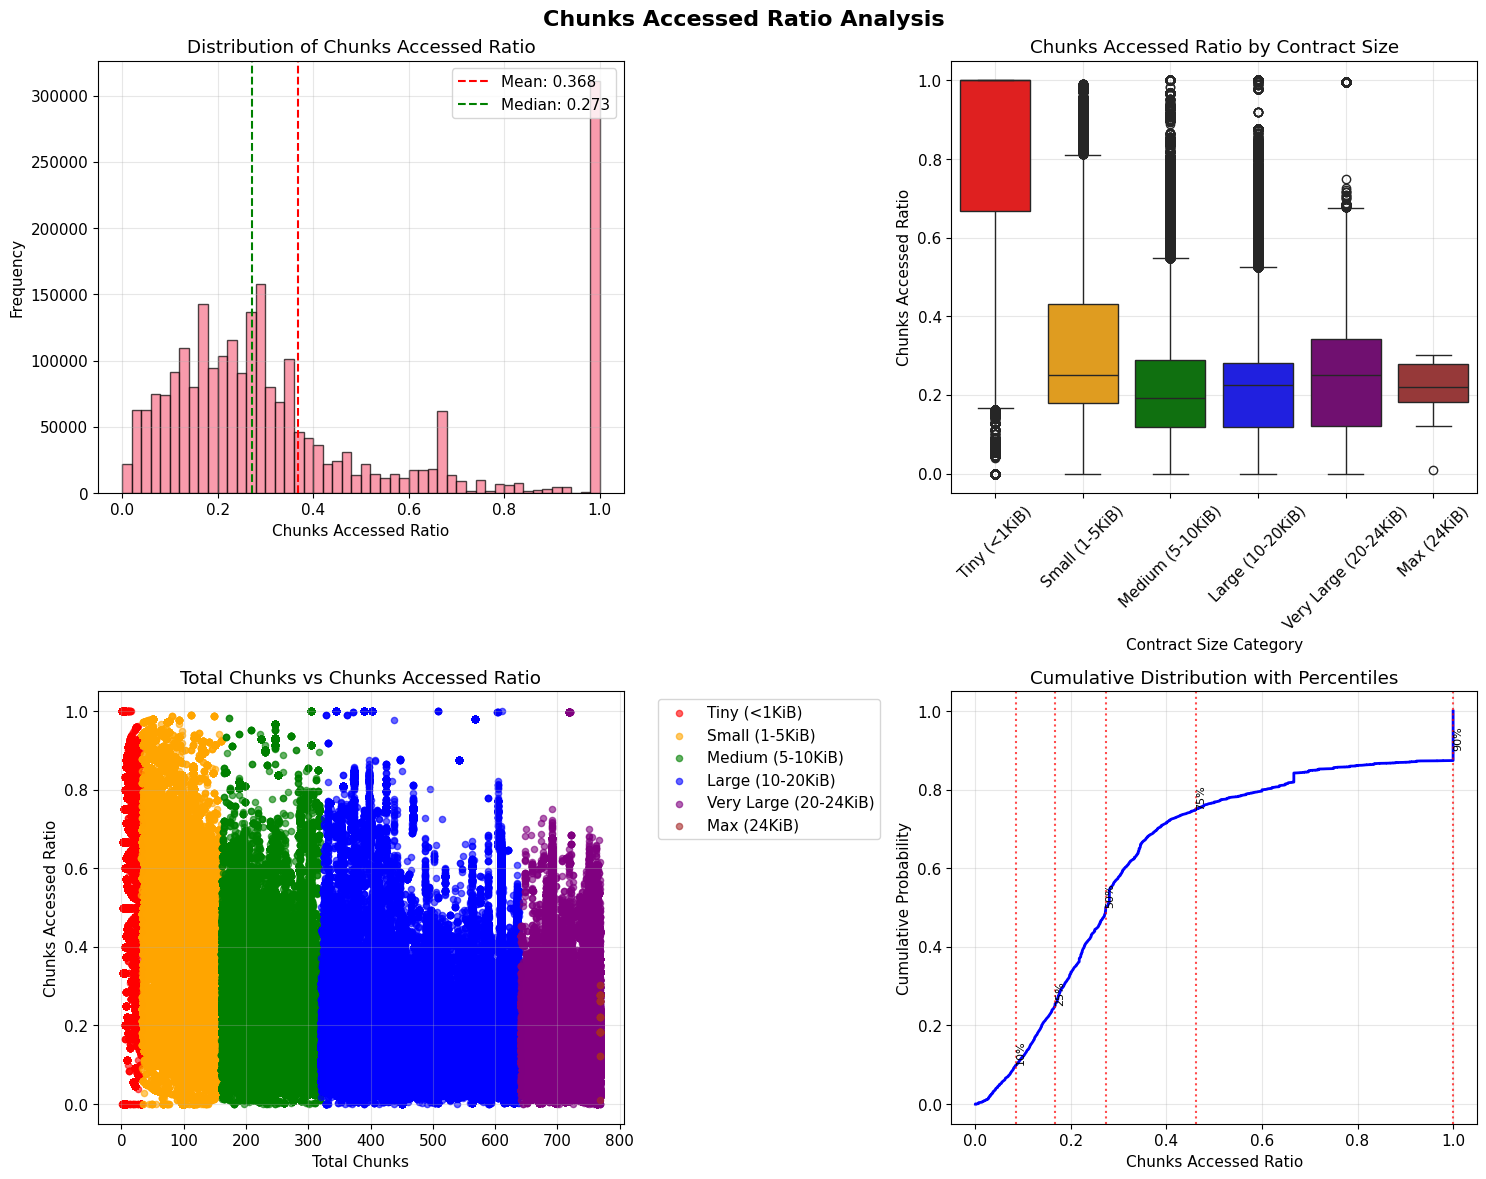


KEY INSIGHTS - Chunks Accessed Ratio:
• Average proportion of chunks accessed: 36.8%
• Median proportion of chunks accessed: 27.3%
• 10th percentile: 8.6%
• 90th percentile: 100.0%
• Contracts with >50% chunks accessed: 569,026 (23.1%)

📊 By Contract Size:
• Tiny (<1KiB): 493,872 contracts, avg 82.4%, median 100.0%
• Small (1-5KiB): 622,277 contracts, avg 31.7%, median 25.0%
• Medium (5-10KiB): 389,900 contracts, avg 21.9%, median 19.2%
• Large (10-20KiB): 556,996 contracts, avg 22.3%, median 22.5%
• Very Large (20-24KiB): 397,220 contracts, avg 23.3%, median 25.1%
• Max (24KiB): 56 contracts, avg 22.6%, median 22.1%


In [115]:
# Analysis of chunks accessed ratio
chunks_ratio_stats = df_analysis['chunks_accessed_ratio'].describe()
print("Chunks Accessed Ratio Statistics:")
print(chunks_ratio_stats)

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Chunks Accessed Ratio Analysis', fontsize=16, fontweight='bold')

# Histogram
axes[0,0].hist(df_analysis['chunks_accessed_ratio'], bins=50, alpha=0.7, edgecolor='black')
axes[0,0].axvline(chunks_ratio_stats['mean'], color='red', linestyle='--', label=f'Mean: {chunks_ratio_stats["mean"]:.3f}')
axes[0,0].axvline(chunks_ratio_stats['50%'], color='green', linestyle='--', label=f'Median: {chunks_ratio_stats["50%"]:.3f}')
axes[0,0].set_xlabel('Chunks Accessed Ratio')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Distribution of Chunks Accessed Ratio')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Colored box plot by contract size using seaborn
sns.boxplot(data=df_analysis, x='size_category', y='chunks_accessed_ratio', 
            palette=['red', 'orange', 'green', 'blue', 'purple', 'brown'],
            ax=axes[0,1])
axes[0,1].set_title('Chunks Accessed Ratio by Contract Size')
axes[0,1].set_xlabel('Contract Size Category')
axes[0,1].set_ylabel('Chunks Accessed Ratio')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(True, alpha=0.3)

# Scatter plot with color coding by size
size_colors = {size_category_labels[0]: 'red', size_category_labels[1]: 'orange', size_category_labels[2]: 'green', 
               size_category_labels[3]: 'blue', size_category_labels[4]: 'purple', size_category_labels[5]: 'brown'}
for size_cat, color in size_colors.items():
    mask = df_analysis['size_category'] == size_cat
    if mask.any():
        axes[1,0].scatter(df_analysis[mask]['total_chunks'], 
                         df_analysis[mask]['chunks_accessed_ratio'], 
                         alpha=0.6, label=size_cat, color=color, s=20)

axes[1,0].set_xlabel('Total Chunks')
axes[1,0].set_ylabel('Chunks Accessed Ratio')
axes[1,0].set_title('Total Chunks vs Chunks Accessed Ratio')
axes[1,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1,0].grid(True, alpha=0.3)

# Cumulative distribution with percentile markers
sorted_chunk_ratios = np.sort(df_analysis['chunks_accessed_ratio'])
y_values = np.arange(1, len(sorted_chunk_ratios) + 1) / len(sorted_chunk_ratios)
axes[1,1].plot(sorted_chunk_ratios, y_values, linewidth=2, color='blue')

# Add percentile markers
percentiles = [10, 25, 50, 75, 90]
for p in percentiles:
    val = np.percentile(df_analysis['chunks_accessed_ratio'], p)
    axes[1,1].axvline(val, color='red', linestyle=':', alpha=0.7)
    axes[1,1].text(val, p/100, f'{p}%', rotation=90, verticalalignment='bottom', fontsize=8)

axes[1,1].set_xlabel('Chunks Accessed Ratio')
axes[1,1].set_ylabel('Cumulative Probability')
axes[1,1].set_title('Cumulative Distribution with Percentiles')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Enhanced insights with contract size breakdown
print(f"\nKEY INSIGHTS - Chunks Accessed Ratio:")
print(f"• Average proportion of chunks accessed: {chunks_ratio_stats['mean']:.1%}")
print(f"• Median proportion of chunks accessed: {chunks_ratio_stats['50%']:.1%}")
print(f"• 10th percentile: {np.percentile(df_analysis['chunks_accessed_ratio'], 10):.1%}")
print(f"• 90th percentile: {np.percentile(df_analysis['chunks_accessed_ratio'], 90):.1%}")
print(f"• Contracts with >50% chunks accessed: {(df_analysis['chunks_accessed_ratio'] > 0.5).sum():,} ({(df_analysis['chunks_accessed_ratio'] > 0.5).mean():.1%})")

# Size-specific insights
print(f"\n📊 By Contract Size:")
size_summary = df_analysis.groupby('size_category')['chunks_accessed_ratio'].agg(['count', 'mean', 'median']).round(3)
for size_cat in size_category_labels:
    if size_cat in size_summary.index:
        count = size_summary.loc[size_cat, 'count']
        mean_ratio = size_summary.loc[size_cat, 'mean']
        median_ratio = size_summary.loc[size_cat, 'median']
        print(f"• {size_cat}: {count:,} contracts, avg {mean_ratio:.1%}, median {median_ratio:.1%}")

## 6. Additional Analysis Questions

### Contract Size Analysis

Analysis by Contract Size Category:
                      bytecode_size                      bytes_accessed_ratio  \
                              count       mean       std                 mean   
size_category                                                                   
Tiny (<1KiB)                 493872    218.116   293.437                0.779   
Small (1-5KiB)               622277   2724.248  1143.678                0.217   
Medium (5-10KiB)             389900   7545.136  1389.006                0.150   
Large (10-20KiB)             556996  13965.315  2971.632                0.163   
Very Large (20-24KiB)        397220  22781.185  1025.814                0.174   
Max (24KiB)                      56  24576.000     0.000                0.186   

                                    chunks_accessed_ratio                \
                         std median                  mean    std median   
size_category                                                             
Tiny (<1K

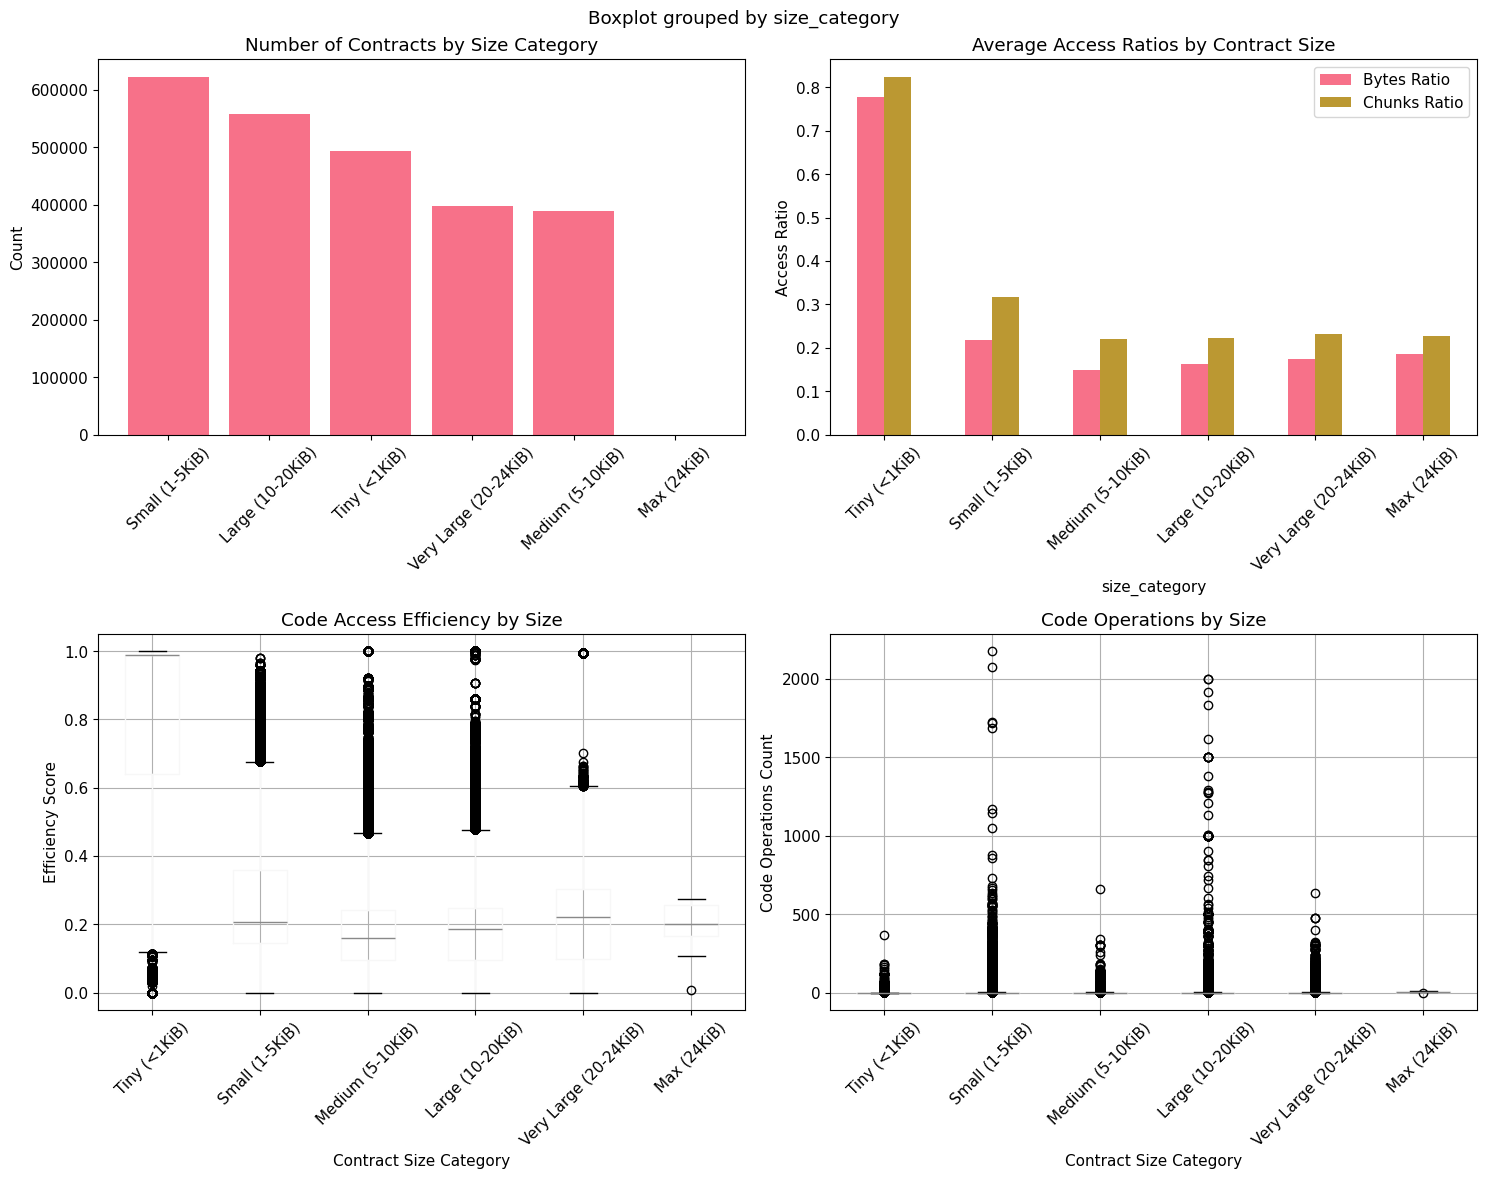

In [116]:
# Analysis by contract size categories
size_analysis = df_analysis.groupby('size_category').agg({
    'bytecode_size': ['count', 'mean', 'std'],
    'bytes_accessed_ratio': ['mean', 'std', 'median'],
    'chunks_accessed_ratio': ['mean', 'std', 'median'],
    'code_ops_count': ['mean', 'std']
}).round(3)

print("Analysis by Contract Size Category:")
print(size_analysis)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Analysis by Contract Size', fontsize=16, fontweight='bold')

# Contract count by size
size_counts = df_analysis['size_category'].value_counts()
axes[0,0].bar(range(len(size_counts)), size_counts.values)
axes[0,0].set_xticks(range(len(size_counts)))
axes[0,0].set_xticklabels(size_counts.index, rotation=45)
axes[0,0].set_title('Number of Contracts by Size Category')
axes[0,0].set_ylabel('Count')

# Average access ratios by size
size_means = df_analysis.groupby('size_category')[['bytes_accessed_ratio', 'chunks_accessed_ratio']].mean()
size_means.plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Average Access Ratios by Contract Size')
axes[0,1].set_ylabel('Access Ratio')
axes[0,1].legend(['Bytes Ratio', 'Chunks Ratio'])
axes[0,1].tick_params(axis='x', rotation=45)

# Efficiency analysis
df_analysis['efficiency_score'] = (df_analysis['bytes_accessed_ratio'] + df_analysis['chunks_accessed_ratio']) / 2
df_analysis.boxplot(column='efficiency_score', by='size_category', ax=axes[1,0])
axes[1,0].set_title('Code Access Efficiency by Size')
axes[1,0].set_xlabel('Contract Size Category')
axes[1,0].set_ylabel('Efficiency Score')
plt.setp(axes[1,0].xaxis.get_majorticklabels(), rotation=45)

# Code operations by size
df_analysis.boxplot(column='code_ops_count', by='size_category', ax=axes[1,1])
axes[1,1].set_title('Code Operations by Size')
axes[1,1].set_xlabel('Contract Size Category')
axes[1,1].set_ylabel('Code Operations Count')
plt.setp(axes[1,1].xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

### Code Operations Analysis

Analysis by Contract Size Category:
                      bytecode_size                      bytes_accessed_ratio  \
                              count       mean       std                 mean   
size_category                                                                   
Tiny (<1KiB)                 493872    218.116   293.437                0.779   
Small (1-5KiB)               622277   2724.248  1143.678                0.217   
Medium (5-10KiB)             389900   7545.136  1389.006                0.150   
Large (10-20KiB)             556996  13965.315  2971.632                0.163   
Very Large (20-24KiB)        397220  22781.185  1025.814                0.174   
Max (24KiB)                      56  24576.000     0.000                0.186   

                                    chunks_accessed_ratio                \
                         std median                  mean    std median   
size_category                                                             
Tiny (<1K

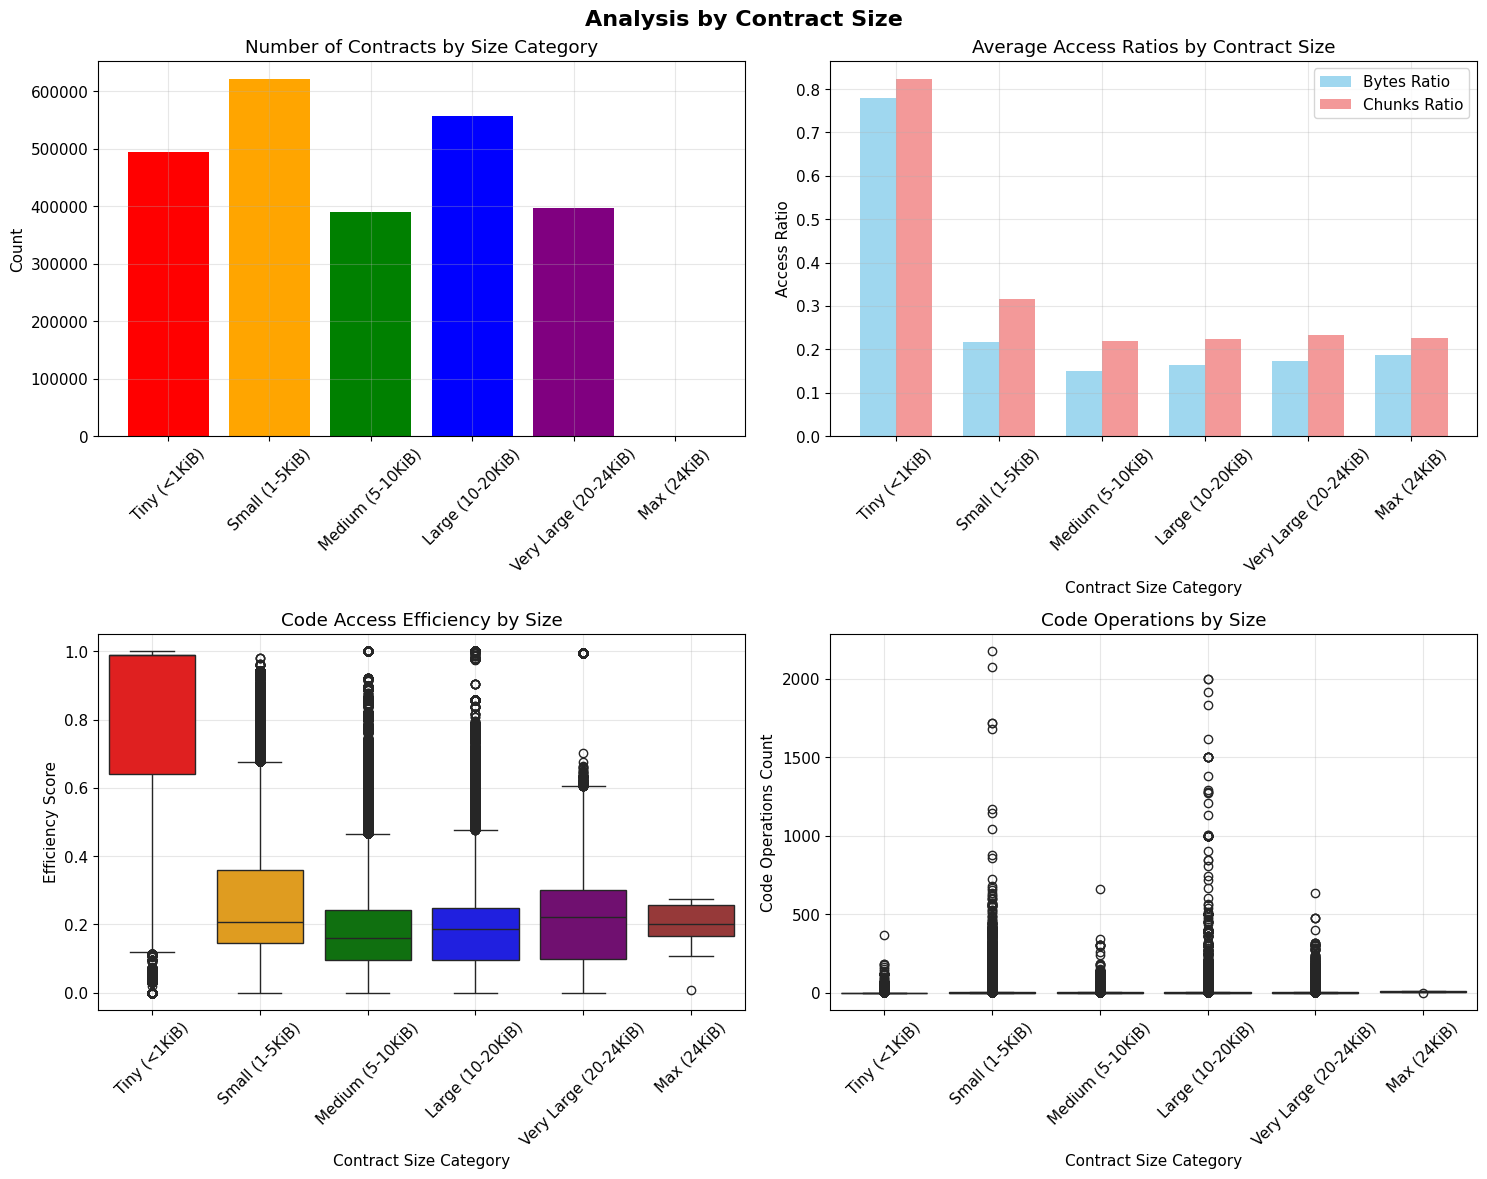

In [117]:
# Analysis by contract size categories
size_analysis = df_analysis.groupby('size_category').agg({
    'bytecode_size': ['count', 'mean', 'std'],
    'bytes_accessed_ratio': ['mean', 'std', 'median'],
    'chunks_accessed_ratio': ['mean', 'std', 'median'],
    'code_ops_count': ['mean', 'std']
}).round(3)

print("Analysis by Contract Size Category:")
print(size_analysis)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Analysis by Contract Size', fontsize=16, fontweight='bold')

# Contract count by size
size_counts = df_analysis['size_category'].value_counts()
size_order = size_category_labels
ordered_counts = [size_counts.get(cat, 0) for cat in size_order]
colors = ['red', 'orange', 'green', 'blue', 'purple', 'brown']
axes[0,0].bar(range(len(size_order)), ordered_counts, color=colors)
axes[0,0].set_xticks(range(len(size_order)))
axes[0,0].set_xticklabels(size_order, rotation=45)
axes[0,0].set_title('Number of Contracts by Size Category')
axes[0,0].set_ylabel('Count')
axes[0,0].grid(True, alpha=0.3)

# Average access ratios by size
size_means = df_analysis.groupby('size_category')[['bytes_accessed_ratio', 'chunks_accessed_ratio']].mean().reindex(size_order)
x_pos = range(len(size_order))
width = 0.35
axes[0,1].bar([x - width/2 for x in x_pos], size_means['bytes_accessed_ratio'], 
              width, label='Bytes Ratio', alpha=0.8, color='skyblue')
axes[0,1].bar([x + width/2 for x in x_pos], size_means['chunks_accessed_ratio'], 
              width, label='Chunks Ratio', alpha=0.8, color='lightcoral')
axes[0,1].set_xlabel('Contract Size Category')
axes[0,1].set_ylabel('Access Ratio')
axes[0,1].set_title('Average Access Ratios by Contract Size')
axes[0,1].set_xticks(x_pos)
axes[0,1].set_xticklabels(size_order, rotation=45)
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Efficiency analysis using colored seaborn box plot
df_analysis['efficiency_score'] = (df_analysis['bytes_accessed_ratio'] + df_analysis['chunks_accessed_ratio']) / 2
sns.boxplot(data=df_analysis, x='size_category', y='efficiency_score', 
            palette=colors, ax=axes[1,0])
axes[1,0].set_title('Code Access Efficiency by Size')
axes[1,0].set_xlabel('Contract Size Category')
axes[1,0].set_ylabel('Efficiency Score')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(True, alpha=0.3)

# Code operations using colored seaborn box plot
sns.boxplot(data=df_analysis, x='size_category', y='code_ops_count', 
            palette=colors, ax=axes[1,1])
axes[1,1].set_title('Code Operations by Size')
axes[1,1].set_xlabel('Contract Size Category')
axes[1,1].set_ylabel('Code Operations Count')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Block-level Analysis

Block-level Analysis:
              Contract_Count  Avg_Bytecode_Size  Total_Bytecode_Size  \
block_number                                                           
22000000                 181           9892.215              1790491   
22000001                 203           8348.931              1694833   
22000002                 161           9815.894              1580359   
22000003                 200           8048.735              1609747   
22000004                 150           6403.147               960472   
22000005                 235           9680.506              2274919   
22000006                 205           9551.424              1958042   
22000007                  56           9987.571               559304   
22000008                 213           4653.897               991280   
22000009                 414           9467.133              3919393   

              Avg_Bytes_Ratio  Avg_Chunks_Ratio  Avg_Code_Ops  Total_Code_Ops  
block_number                     

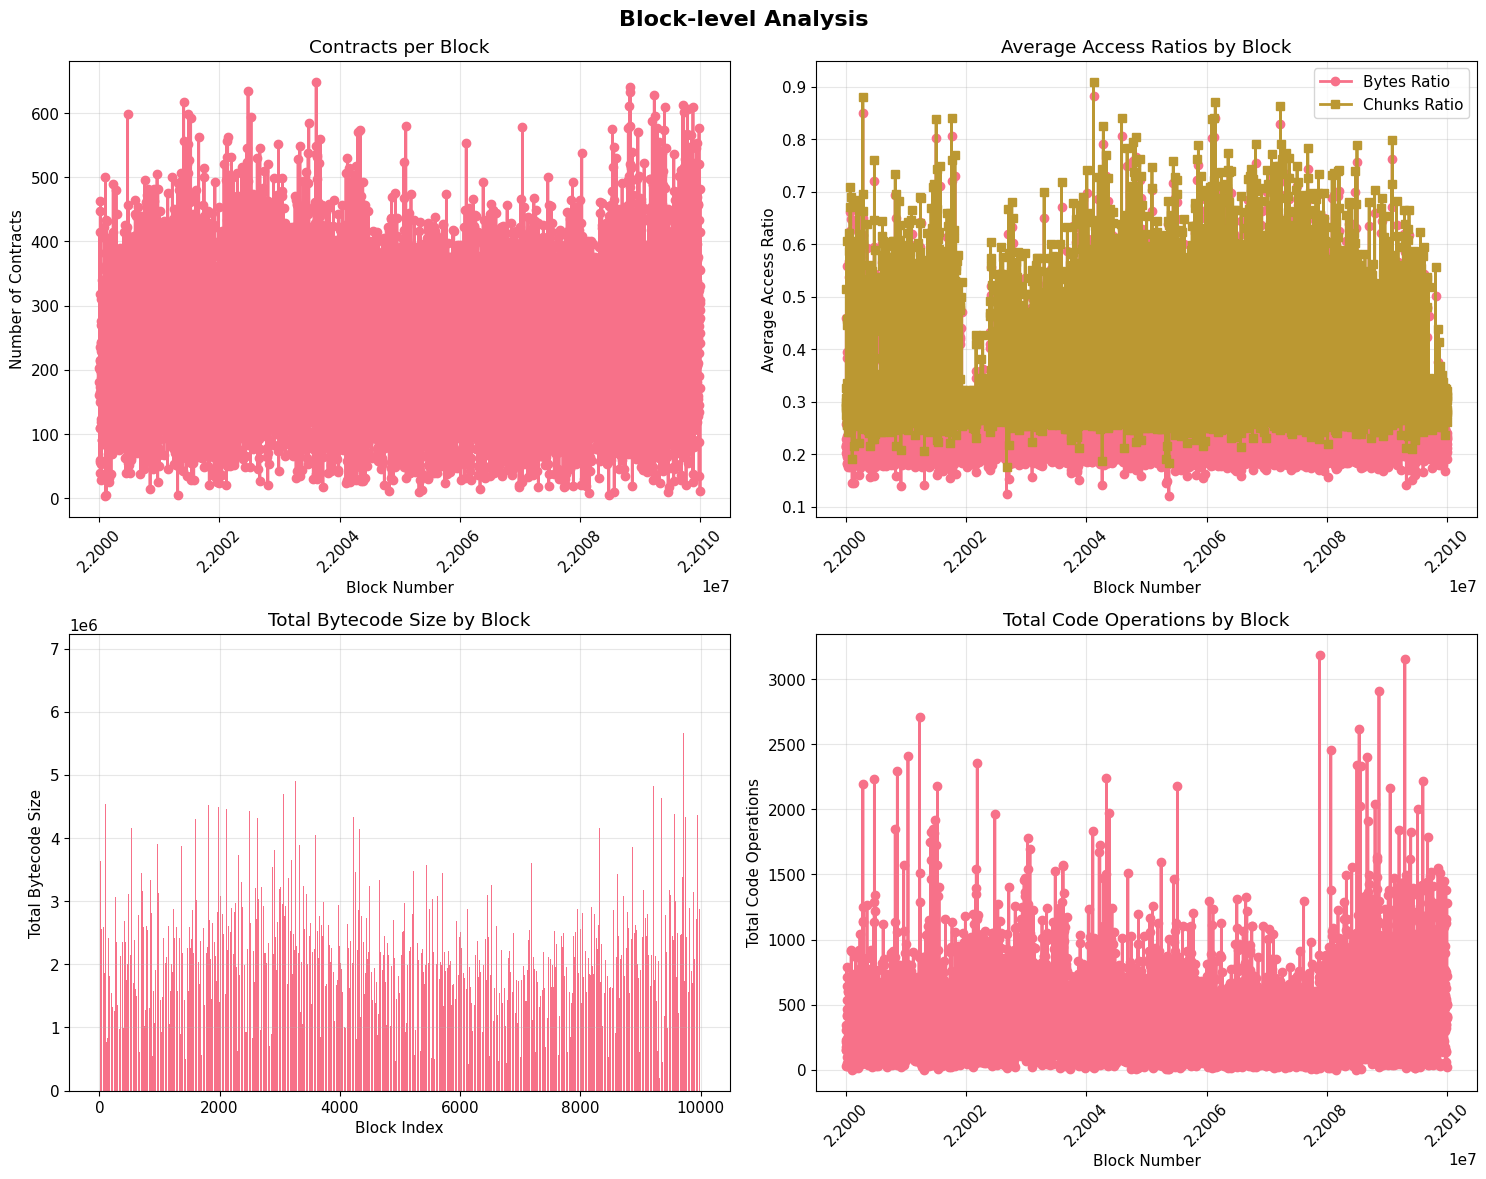

In [118]:
# Block-level analysis
block_analysis = df_analysis.groupby('block_number').agg({
    'address': 'count',
    'bytecode_size': ['mean', 'sum'],
    'bytes_accessed_ratio': 'mean',
    'chunks_accessed_ratio': 'mean',
    'code_ops_count': ['mean', 'sum']
}).round(3)

block_analysis.columns = ['Contract_Count', 'Avg_Bytecode_Size', 'Total_Bytecode_Size', 
                         'Avg_Bytes_Ratio', 'Avg_Chunks_Ratio', 'Avg_Code_Ops', 'Total_Code_Ops']

print("Block-level Analysis:")
print(block_analysis.head(10))

print(f"\nBlock-level Statistics:")
print(f"Blocks analyzed: {len(block_analysis)}")
print(f"Average contracts per block: {block_analysis['Contract_Count'].mean():.1f}")
print(f"Block with most contracts: {block_analysis['Contract_Count'].idxmax()} ({block_analysis['Contract_Count'].max()} contracts)")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Block-level Analysis', fontsize=16, fontweight='bold')

# Contracts per block
axes[0,0].plot(block_analysis.index, block_analysis['Contract_Count'], marker='o', linewidth=2)
axes[0,0].set_xlabel('Block Number')
axes[0,0].set_ylabel('Number of Contracts')
axes[0,0].set_title('Contracts per Block')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].tick_params(axis='x', rotation=45)

# Average access ratios by block
axes[0,1].plot(block_analysis.index, block_analysis['Avg_Bytes_Ratio'], marker='o', label='Bytes Ratio', linewidth=2)
axes[0,1].plot(block_analysis.index, block_analysis['Avg_Chunks_Ratio'], marker='s', label='Chunks Ratio', linewidth=2)
axes[0,1].set_xlabel('Block Number')
axes[0,1].set_ylabel('Average Access Ratio')
axes[0,1].set_title('Average Access Ratios by Block')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)
axes[0,1].tick_params(axis='x', rotation=45)

# Total bytecode size by block
axes[1,0].bar(range(len(block_analysis)), block_analysis['Total_Bytecode_Size'])
axes[1,0].set_xlabel('Block Index')
axes[1,0].set_ylabel('Total Bytecode Size')
axes[1,0].set_title('Total Bytecode Size by Block')
axes[1,0].grid(True, alpha=0.3)

# Code operations by block
axes[1,1].plot(block_analysis.index, block_analysis['Total_Code_Ops'], marker='o', linewidth=2)
axes[1,1].set_xlabel('Block Number')
axes[1,1].set_ylabel('Total Code Operations')
axes[1,1].set_title('Total Code Operations by Block')
axes[1,1].grid(True, alpha=0.3)
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 8. Summary and Key Findings

Block-level Analysis:
              Contract_Count  Avg_Bytecode_Size  Total_Bytecode_Size  \
block_number                                                           
22000000                 181           9892.215              1790491   
22000001                 203           8348.931              1694833   
22000002                 161           9815.894              1580359   
22000003                 200           8048.735              1609747   
22000004                 150           6403.147               960472   
22000005                 235           9680.506              2274919   
22000006                 205           9551.424              1958042   
22000007                  56           9987.571               559304   
22000008                 213           4653.897               991280   
22000009                 414           9467.133              3919393   

              Avg_Bytes_Ratio  Avg_Chunks_Ratio  Avg_Code_Ops  Total_Code_Ops  
block_number                     

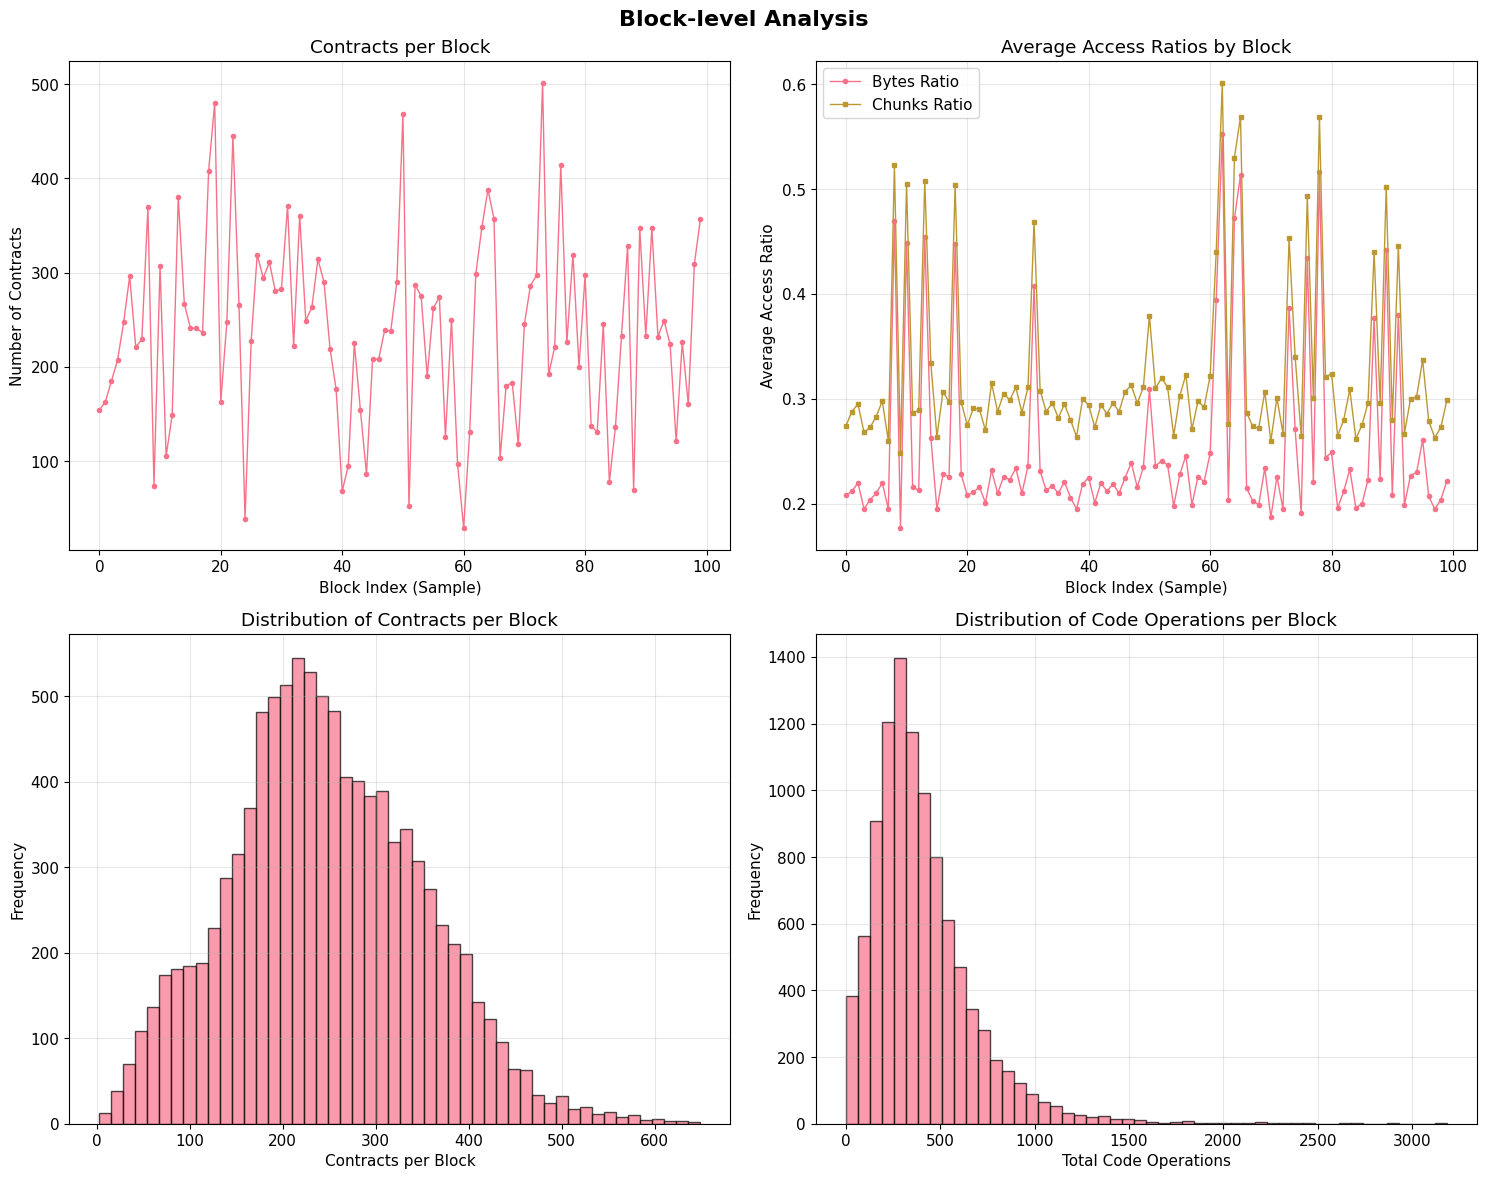


Block-level Distribution:
Contracts per block - Min: 3, Max: 649
Contracts per block - Mean: 246.2, Median: 239.0
Blocks with <100 contracts: 805
Blocks with 100-500 contracts: 9072
Blocks with 500+ contracts: 116


In [119]:
# Block-level analysis
block_analysis = df_analysis.groupby('block_number').agg({
    'address': 'count',
    'bytecode_size': ['mean', 'sum'],
    'bytes_accessed_ratio': 'mean',
    'chunks_accessed_ratio': 'mean',
    'code_ops_count': ['mean', 'sum']
}).round(3)

block_analysis.columns = ['Contract_Count', 'Avg_Bytecode_Size', 'Total_Bytecode_Size', 
                         'Avg_Bytes_Ratio', 'Avg_Chunks_Ratio', 'Avg_Code_Ops', 'Total_Code_Ops']

print("Block-level Analysis:")
print(block_analysis.head(10))

print(f"\nBlock-level Statistics:")
print(f"Blocks analyzed: {len(block_analysis)}")
print(f"Average contracts per block: {block_analysis['Contract_Count'].mean():.1f}")
print(f"Block with most contracts: {block_analysis['Contract_Count'].idxmax()} ({block_analysis['Contract_Count'].max()} contracts)")

# Visualization - sample blocks for readability if too many
sample_size = min(100, len(block_analysis))  # Show max 100 blocks for readability
if len(block_analysis) > sample_size:
    block_sample = block_analysis.sample(n=sample_size, random_state=42).sort_index()
    print(f"\nNote: Showing sample of {sample_size} blocks for visualization clarity")
else:
    block_sample = block_analysis

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Block-level Analysis', fontsize=16, fontweight='bold')

# Contracts per block
axes[0,0].plot(range(len(block_sample)), block_sample['Contract_Count'], 
               marker='o', linewidth=1, markersize=3)
axes[0,0].set_xlabel('Block Index (Sample)')
axes[0,0].set_ylabel('Number of Contracts')
axes[0,0].set_title('Contracts per Block')
axes[0,0].grid(True, alpha=0.3)

# Average access ratios by block
axes[0,1].plot(range(len(block_sample)), block_sample['Avg_Bytes_Ratio'], 
               marker='o', label='Bytes Ratio', linewidth=1, markersize=3)
axes[0,1].plot(range(len(block_sample)), block_sample['Avg_Chunks_Ratio'], 
               marker='s', label='Chunks Ratio', linewidth=1, markersize=3)
axes[0,1].set_xlabel('Block Index (Sample)')
axes[0,1].set_ylabel('Average Access Ratio')
axes[0,1].set_title('Average Access Ratios by Block')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Distribution of contracts per block (histogram)
axes[1,0].hist(block_analysis['Contract_Count'], bins=50, alpha=0.7, edgecolor='black')
axes[1,0].set_xlabel('Contracts per Block')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('Distribution of Contracts per Block')
axes[1,0].grid(True, alpha=0.3)

# Code operations distribution
axes[1,1].hist(block_analysis['Total_Code_Ops'], bins=50, alpha=0.7, edgecolor='black')
axes[1,1].set_xlabel('Total Code Operations')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Distribution of Code Operations per Block')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional block-level insights
print(f"\nBlock-level Distribution:")
print(f"Contracts per block - Min: {block_analysis['Contract_Count'].min()}, Max: {block_analysis['Contract_Count'].max()}")
print(f"Contracts per block - Mean: {block_analysis['Contract_Count'].mean():.1f}, Median: {block_analysis['Contract_Count'].median():.1f}")
print(f"Blocks with <100 contracts: {(block_analysis['Contract_Count'] < 100).sum()}")
print(f"Blocks with 100-500 contracts: {((block_analysis['Contract_Count'] >= 100) & (block_analysis['Contract_Count'] < 500)).sum()}")
print(f"Blocks with 500+ contracts: {(block_analysis['Contract_Count'] >= 500).sum()}")